<a href="https://colab.research.google.com/github/zw2497/LandmarkRecognition/blob/master/landmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from tensorflow.keras import optimizers, models

# Download landmark dataset from my Github
This dataset has 3 training classes. This dataset is extracted from the video I recorded. It also contain 78 test pictures from **the internet** which is more appropriate for test.
### alma mater
    training: 334
    test: 26
### schoalr's lion 
    training: 334
    test: 26
### meadmore curl
    training: 334
    test: 26




In [0]:
!wget https://github.com/zw2497/LandmarkRecognition/releases/download/v0.2/newdataset.zip -O /tmp/landmark_dataset.zip

In [0]:
local_zip = '/tmp/landmark_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/landmark_dataset')
zip_ref.close()

In [41]:
!rm -rf /tmp/landmark_dataset/newdataset/__MACOSX/
!rm /tmp/landmark_dataset/newdataset/train/.DS_Store
!ls /tmp/landmark_dataset/newdataset/train

alma  lion  mead


# Split training dataset into training and validation

In [0]:
base_dir = '/tmp/landmark_dataset/newdataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [64]:
BATCH_SIZE = 32
TARGET_SHAPE = 132
train_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=train_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              subset='training',
                                                              class_mode='sparse',
                                                              shuffle=True
                                                     
                                                    )
val_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=train_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              subset='validation',
                                                              class_mode='sparse',
                                                              shuffle=True
                                                  )
test_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=test_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='sparse',
                                                              shuffle=True
                                                  )
total_train = train_data_gen.n
total_val = val_data_gen.n
print(total_train,total_val)

Found 702 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 77 images belonging to 3 classes.
702 297


# View Training Dataset: from my recorded videos

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)
sample_test_images, sample_training_labels = next(test_data_gen)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

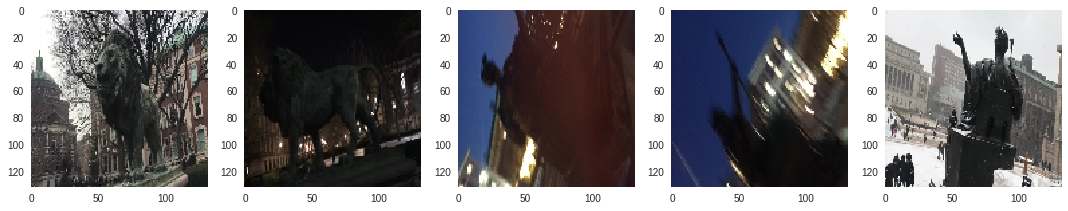

In [46]:
plotImages(sample_training_images[:5])

# View Test Dataset: from Google Image

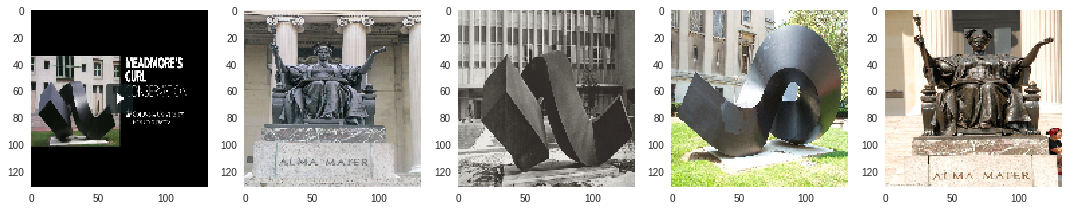

In [103]:
plotImages(sample_test_images[:5])

In [105]:
label_names = os.listdir(train_dir)
label_dirs = [os.path.join(train_dir, i) for i in label_names]
os.listdir(train_dir)
for label_name, label_dir  in zip(os.listdir(train_dir), label_dirs):
  print(label_name, '- Training:',len(os.listdir(label_dir)))

mead - Training: 334
alma - Training: 334
lion - Training: 334


# Import pretrained model: VGG

In [0]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [92]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 11,276,805
Non-trainable params: 7,635,264
_________________________________________________________________


In [97]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 11,276,805
Non-trainable params: 7,635,264
_________________________________________________________________


In [98]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/10
22/22 [==============================] - 16s 738ms/step - loss: 1.3363 - acc: 0.3818 - val_loss: 0.9954 - val_acc: 0.6768
Epoch 2/10
22/22 [==============================] - 14s 628ms/step - loss: 0.7040 - acc: 0.8818 - val_loss: 0.6707 - val_acc: 0.8855
Epoch 3/10
22/22 [==============================] - 14s 634ms/step - loss: 0.3371 - acc: 0.9858 - val_loss: 0.4389 - val_acc: 0.9226
Epoch 4/10
22/22 [==============================] - 14s 638ms/step - loss: 0.1522 - acc: 0.9986 - val_loss: 0.2870 - val_acc: 0.9226
Epoch 5/10
22/22 [==============================] - 14s 623ms/step - loss: 0.0705 - acc: 1.0000 - val_loss: 0.2079 - val_acc: 0.9226
Epoch 6/10
22/22 [==============================] - 14s 639ms/step - loss: 0.0347 - acc: 1.0000 - val_loss: 0.1840 - val_acc: 0.9259
Epoch 7/10
22/22 [==============================] - 14s 622ms/step - loss: 0.0179 - acc: 1.0000 - val_loss: 0.1681 - val_acc: 0.9327
Epoch 8/10
22/22 [==============================] - 14s 615ms/step - 

# VGG with Fine Tuning

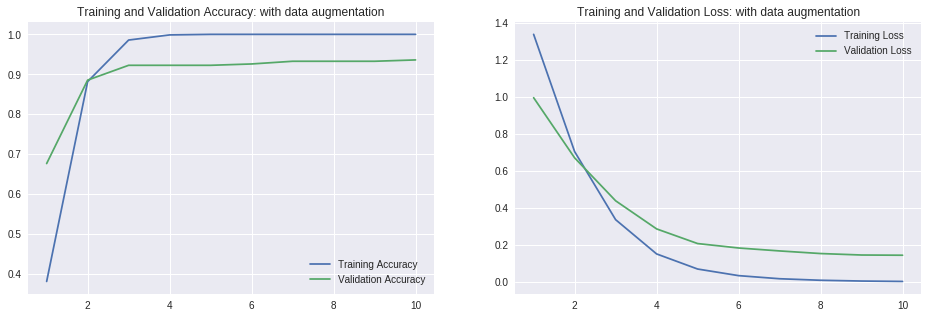

In [99]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with data augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with data augmentation')
plt.show()

# Saving Model

In [0]:
models.save_model(
    model,
    '/tmp/save',
    overwrite=True,
    include_optimizer=True
)

# Evaluate Test data from Google Image

In [90]:
model.evaluate(test_data_gen)

3/3 [==============================] - 3s 905ms/step - loss: 0.3951 - acc: 0.8961


[0.39507444202899933, 0.8961039]